In [0]:
import argparse
import os
import sys
import warnings
import keras
import keras.preprocessing.image
import tensorflow as tf
import keras_retinanet.bin
from keras_retinanet import layers  
from keras_retinanet import losses
from keras_retinanet import models
from keras_retinanet.callbacks import RedirectModel
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.preprocessing.kitti import KittiGenerator
from keras_retinanet.preprocessing.open_images import OpenImagesGenerator
from keras_retinanet.preprocessing.pascal_voc import PascalVocGenerator
from keras_retinanet.utils.anchors import make_shapes_callback
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters
from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.utils.image import random_visual_effect_generator
from keras_retinanet.utils.keras_version import check_keras_version
from keras_retinanet.utils.model import freeze as freeze_model
from keras_retinanet.utils.tf_version import check_tf_version
from keras_retinanet.utils.transform import random_transform_generator
import xml.etree.ElementTree as ET
import csv
from keras_retinanet.utils.gpu import setup_gpu
setup_gpu(0)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [0]:
DATASET_DIR = '/content/drive/My Drive/ships2/ships2'
ANNOTATIONS_FILE = 'annotations2.csv'
CLASSES_FILE = 'classes2.csv'

In [0]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
    tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
    root = tree.getroot()
    file_name = None
    for elem in root:
        if elem.tag == 'filename':
            file_name = os.path.join(DATASET_DIR, elem.text)
        if elem.tag == 'object':
            obj_name = None
            coords = []
            for subelem in elem:
                if subelem.tag == 'name':
                    obj_name = subelem.text
                if subelem.tag == 'bndbox':
                    for subsubelem in subelem:
                        coords.append(subsubelem.text)
            item = [file_name] + coords + [obj_name]
            annotations.append(item)
            classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
    for i, line in enumerate(classes):
        f.write('{},{}\n'.format(line,i))



In [0]:
tensorboard_dir='/content/drive/My Drive/keras-retinanet-master/'
snapshot_path='/content/drive/My Drive/keras-retinanet-master/'
weighted_average='store_true'
evaluation='store_false'
#compute-val-loss='store_true'
config='store_true'
imagenet_weights='store_const'
backbone='resnet50'
dataset_type='csv'
annotations='annotations2.csv'
classes='classes2.csv'
random_transform='store_true'
batch_size=1
image_min_side=800
image_max_side=1333
no_resize='store_true'

In [0]:
def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

In [0]:
def model_with_weights(model, weights, skip_mismatch):
    if weights is not None:
        model.load_weights(weights, by_name=True, skip_mismatch=skip_mismatch)
        return model


In [0]:
def create_models(backbone_retinanet, num_classes, weights, multi_gpu=0,freeze_backbone=False, lr=1e-5, config=None):
    modifier = freeze_model if freeze_backbone else None
    # load anchor parameters, or pass None (so that defaults will be used)
    anchor_params = None
    num_anchors   = None
    if config and 'anchor_parameters' in config:
        anchor_params = parse_anchor_parameters(config)
        num_anchors   = anchor_params.num_anchors()
        # Keras recommends initialising a multi-gpu model on the CPU to ease weight sharing, and to prevent OOM errors.
        # optionally wrap in a parallel model
    if multi_gpu > 1:
        from keras.utils import multi_gpu_model
        with tf.device('/cpu:0'):
            model = model_with_weights(backbone_retinanet(num_classes, num_anchors=num_anchors, modifier=modifier), weights=weights, skip_mismatch=True)
            training_model = multi_gpu_model(model, gpus=multi_gpu)
    else:
        model= model_with_weights(backbone_retinanet(num_classes, num_anchors=num_anchors, modifier=modifier), weights=weights, skip_mismatch=True)
        training_model = model
    # make prediction model
    prediction_model = retinanet_bbox(model=model, anchor_params=anchor_params)
    # compile model
    training_model.compile(loss={'regression': losses.smooth_l1(),'classification': losses.focal()},optimizer=keras.optimizers.adam(lr=lr, clipnorm=0.001))
    return model, training_model, prediction_model


In [0]:
def create_callbacks(model, training_model, prediction_model):
    callbacks = []
    tensorboard_callback = None
    if tensorboard_dir:
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir= tensorboard_dir,histogram_freq= 0,batch_size = batch_size,write_graph=True,write_grads= False,write_images= False,embeddings_freq= 0,embeddings_layer_names = None,embeddings_metadata= None)
    makedirs(snapshot_path)
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(snapshot_path,'{backbone}_{dataset_type}_{{epoch:02d}}.h5'.format(backbone=backbone, dataset_type=dataset_type)),verbose=1)
    checkpoint = RedirectModel(checkpoint, model)
    callbacks.append(checkpoint)
    
    callbacks.append(keras.callbacks.ReduceLROnPlateau(monitor= 'loss',factor= 0.1,patience= 2,verbose= 1,mode='auto',min_delta = 0.0001,cooldown= 0,min_lr=0))
    callbacks.append(keras.callbacks.EarlyStopping(monitor= 'mAP',patience= 5,mode= 'max',min_delta = 0.01))
    if tensorboard_dir:
        callbacks.append(tensorboard_callback)
    return callbacks

In [0]:
def create_generators(preprocess_image):
    common_args = {'batch_size':batch_size,'config':config,'image_min_side': image_min_side,'image_max_side': image_max_side,'no_resize': no_resize,'preprocess_image': preprocess_image}
    # create random transform generator for augmenting training data
    if random_transform:
        transform_generator = random_transform_generator(min_rotation=-0.1,max_rotation=0.1,min_translation=(-0.1, -0.1),max_translation=(0.1, 0.1),min_shear=-0.1,max_shear=0.1,min_scaling=(0.9, 0.9),max_scaling=(1.1, 1.1),flip_x_chance=0.5,flip_y_chance=0.5,)
        visual_effect_generator = random_visual_effect_generator(contrast_range=(0.9, 1.1),brightness_range=(-.1, .1),hue_range=(-0.05, 0.05),saturation_range=(0.95, 1.05))
    else:
        transform_generator = random_transform_generator(flip_x_chance=0.5)
        visual_effect_generator = None

    if dataset_type == 'csv':
        train_generator = CSVGenerator(annotations,classes,transform_generator=transform_generator,visual_effect_generator=visual_effect_generator,**common_args)
    return train_generator



In [0]:
def main():
    # create object that stores backbone information
    backbone = models.backbone('resnet50')
    # create the generators
    train_generator = create_generators(backbone.preprocess_image)
    weights=None
    # default to imagenet if nothing else is specified
    if weights is None and imagenet_weights:
        weights = backbone.download_imagenet()
    print('Creating model, this may take a second...')
    model, training_model, prediction_model = create_models(backbone_retinanet=backbone.retinanet,num_classes=train_generator.num_classes(),weights=weights,multi_gpu=0,freeze_backbone='store_true',lr=1e-5,config=config)

    # print model summary
    print(model.summary())

  
    # create the callbacks
    callbacks = create_callbacks(model,training_model,prediction_model)

    # start training
    return training_model.fit_generator(generator=train_generator,steps_per_epoch=1000,epochs=10,verbose=1,callbacks=callbacks,workers=1,use_multiprocessing='store_true',max_queue_size=10,initial_epoch=0)

In [0]:
main()

Creating model, this may take a second...
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.3174

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


Epoch 1/10
   2/1000 [..............................] - ETA: 48:30 - loss: 3.9172 - regression_loss: 2.7876 - classification_loss: 1.1296  

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.348104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1000/1000 [==============================] - 1124s 1s/step - loss: 2.9805 - regression_loss: 2.1716 - classification_loss: 0.8088

Epoch 00001: saving model to /content/drive/My Drive/keras-retinanet-master/resnet50_csv_01.h5


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `mAP` which is not available. Available metrics are: loss,regression_loss,classification_loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/10
 943/1000 [===========================>..] - ETA: 1:03 - loss: 2.0264 - regression_loss: 1.6475 - classification_loss: 0.3788

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


1000/1000 [==============================] - 1145s 1s/step - loss: 2.0175 - regression_loss: 1.6420 - classification_loss: 0.3755

Epoch 00002: saving model to /content/drive/My Drive/keras-retinanet-master/resnet50_csv_02.h5
Epoch 3/10
1000/1000 [==============================] - 1119s 1s/step - loss: 1.5654 - regression_loss: 1.3098 - classification_loss: 0.2556

Epoch 00003: saving model to /content/drive/My Drive/keras-retinanet-master/resnet50_csv_03.h5
Epoch 4/10
1000/1000 [==============================] - 1135s 1s/step - loss: 1.2710 - regression_loss: 1.0490 - classification_loss: 0.2219

Epoch 00004: saving model to /content/drive/My Drive/keras-retinanet-master/resnet50_csv_04.h5
Epoch 5/10
1000/1000 [==============================] - 1114s 1s/step - loss: 1.0395 - regression_loss: 0.8584 - classification_loss: 0.1811

Epoch 00005: saving model to /content/drive/My Drive/keras-retinanet-master/resnet50_csv_05.h5
Epoch 6/10
1000/1000 [==============================] - 1109s 1

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pandas as pd

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

In [0]:
model_path ='/content/drive/My Drive/keras-retinanet-master/resnet50_csv_10.h5'
# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [0]:
def img_inference(img_path):
    image = read_image_bgr(img_infer)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    # correct for image scale
    boxes /= scale
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < THRES_SCORE:
            break
        color = label_color(label)
        b = box.astype(int)
        draw_box(draw, b, color=color)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw)
plt.show()

processing time:  1.5128147602081299


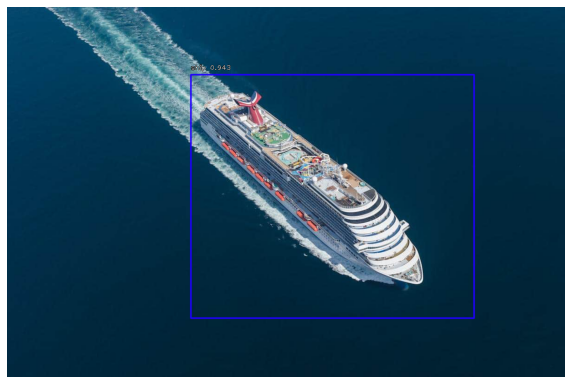

In [0]:
THRES_SCORE=0.5
img_infer='/content/drive/My Drive/ships2/ships2/cruize3.jpg'
img_inference(img_infer)